**Coding 2: Assignment 2**
# Investigating The Relationship Between Urbanization and Happiness
Ambrus Vince Fodor

## Introduction

Urbanization is reshaping the global population. More people are moving to cities for economic opportunities and better access to services. But there's a persistent belief across the political spectrum that rural living is inherently more happy, since life is simpler, community bonds are stronger, and wellbeing is higher. Is there evidence to support this, or is it mainly nostalgia towards a never existing "golden age"? 

This analysis examines the relationship between urbanization and life satisfaction across countries using data from the World Happiness Report and the World Bank. We ask: Are residents of more urbanized countries less satisfied with their lives? Does controlling for economic factors (like GDP, unemployment, and education) change this relationship?

In [112]:
import requests
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

## I. Preparing the data
**1.1 World Happiness Report**

In [62]:
happiness = pd.read_excel("./data/WHR25.xlsx")
happiness

,Year,Rank,Country name,Life evaluation (3-year average),Lower whisker,Upper whisker,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,2024,147,Afghanistan,1.364,1.301,1.427,0.649,0.0,0.155,0.0,0.075,0.135,0.348
1,2023,143,Afghanistan,1.721,1.667,1.775,0.628,0.0,0.242,0.0,0.091,0.088,0.672
2,2022,137,Afghanistan,1.859,1.795,1.923,0.645,0.0,0.087,0.0,0.093,0.059,0.976
3,2021,146,Afghanistan,2.404,2.339,2.469,0.758,0.0,0.289,0.0,0.089,0.005,1.263
4,2020,150,Afghanistan,2.523,2.449,2.596,0.370,0.0,0.126,0.0,0.122,0.010,1.895
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016,138,Zimbabwe,3.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965,2015,131,Zimbabwe,4.193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1966,2014,115,Zimbabwe,4.610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1967,2012,103,Zimbabwe,4.827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
happiness = happiness.filter(items=happiness.columns[[0,2,3]])
happiness.rename(columns={"Year" : "year",
                          "Country name": "country_name",
                          happiness.columns[2]: "life_eval"}, inplace=True)

In [64]:
happiness

,year,country_name,life_eval
0,2024,Afghanistan,1.364
1,2023,Afghanistan,1.721
2,2022,Afghanistan,1.859
3,2021,Afghanistan,2.404
4,2020,Afghanistan,2.523
...,...,...,...
1964,2016,Zimbabwe,3.875
1965,2015,Zimbabwe,4.193
1966,2014,Zimbabwe,4.610
1967,2012,Zimbabwe,4.827


**1.2. WB Data**

In [65]:
wb_data = pd.read_csv("./data/wb_data.csv")
wb_data.head()

,Country Name,Country Code,Series Name,Series Code,2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023],2024 [YR2024]
0,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,11.8041858089129,6.44121280934116,7.38577178397856,4.67399603536345,-0.661709164713771,4.38389195513915,4.97595150553836,0.626149149168802,2.30237251516839,5.60188791482222,5.1332034082496,13.7121023720065,-4.64470870797776,-6.60118564073727
1,Afghanistan,AFG,Gini index,SI.POV.GINI,..,..,..,..,..,..,..,..,..,..,..,..,..,..
2,Afghanistan,AFG,"GDP per capita, PPP (constant 2021 internation...",NY.GDP.PCAP.PP.KD,2757.05258747725,2985.31914452845,3046.57993117128,3017.94254424696,2967.692067153,2958.7853992308,2952.99891598909,2902.39211285546,2927.2451435353,2769.68574507111,2144.16657002819,1981.71016810561,1983.81261992909,..
3,Afghanistan,AFG,Urban population (% of total population),SP.URB.TOTL.IN.ZS,23.948,24.16,24.373,24.587,24.803,25.02,25.25,25.495,25.754,26.026,26.314,26.616,26.933,27.265
4,Afghanistan,AFG,"School enrollment, tertiary (% gross)",SE.TER.ENRR,3.68686008453369,..,..,8.39764022827148,..,..,..,9.99592018127441,..,10.85435962677,..,..,..,..


In [66]:
wb_data.drop(columns=["Series Code", "Country Code"],inplace=True)
wb_data = wb_data.melt(id_vars=["Country Name", "Series Name"], value_vars=wb_data.columns[[2,3,4,5,6,7,8,9,10,11,12,13,14,15]], var_name="year", value_name="value")
wb_data

,Country Name,Series Name,year,value
0,Afghanistan,"Inflation, consumer prices (annual %)",2011 [YR2011],11.8041858089129
1,Afghanistan,Gini index,2011 [YR2011],..
2,Afghanistan,"GDP per capita, PPP (constant 2021 internation...",2011 [YR2011],2757.05258747725
3,Afghanistan,Urban population (% of total population),2011 [YR2011],23.948
4,Afghanistan,"School enrollment, tertiary (% gross)",2011 [YR2011],3.68686008453369
...,...,...,...,...
21331,NaN,NaN,2024 [YR2024],NaN
21332,NaN,NaN,2024 [YR2024],NaN
21333,NaN,NaN,2024 [YR2024],NaN
21334,Data from database: World Development Indicators,NaN,2024 [YR2024],NaN


In [67]:
wb_data.info()
wb_data["value"] = pd.to_numeric(wb_data["value"], "coerce")
wb_data["year"] = wb_data["year"].str.split(" ", expand=True)[0]
wb_data["year"] = pd.to_numeric(wb_data["year"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21336 entries, 0 to 21335
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country Name  21294 non-null  object
 1   Series Name   21266 non-null  object
 2   year          21336 non-null  object
 3   value         21266 non-null  object
dtypes: object(4)
memory usage: 666.9+ KB


In [68]:
wb_data = (
    wb_data
    .pivot_table(
        index=["Country Name", "year"],
        columns="Series Name",
        values="value"
    )
    .reset_index()
)
wb_data

Series Name,Country Name,year,"GDP per capita, PPP (constant 2021 international $)",Gini index,"Inflation, consumer prices (annual %)","Life expectancy at birth, total (years)","School enrollment, tertiary (% gross)","Unemployment, total (% of total labor force) (national estimate)",Urban population (% of total population)
0,Afghanistan,2011,2757.052587,NaN,11.804186,61.250,3.68686,NaN,23.948
1,Afghanistan,2012,2985.319145,NaN,6.441213,61.735,NaN,1.692,24.160
2,Afghanistan,2013,3046.579931,NaN,7.385772,62.188,NaN,NaN,24.373
3,Afghanistan,2014,3017.942544,NaN,4.673996,62.260,8.39764,7.915,24.587
4,Afghanistan,2015,2967.692067,NaN,-0.661709,62.270,NaN,NaN,24.803
...,...,...,...,...,...,...,...,...,...
3032,Zimbabwe,2020,2987.268413,NaN,557.201817,61.530,NaN,NaN,32.242
3033,Zimbabwe,2021,3184.784602,NaN,98.546105,60.135,NaN,9.459,32.303
3034,Zimbabwe,2022,3323.118318,NaN,104.705171,62.360,NaN,10.001,32.395
3035,Zimbabwe,2023,3442.248887,NaN,NaN,62.775,NaN,9.290,32.517


In [69]:
wb_data.rename(columns={wb_data.columns[2]: "gdp_ppp",
                        wb_data.columns[3]: "gini_index",
                        wb_data.columns[4]: "inflation_pc",
                        wb_data.columns[5]: "life_expectancy",
                        wb_data.columns[6]: "tertiary_enrollment",
                        wb_data.columns[7]: "unemployment_pc",
                        wb_data.columns[8]: "urbanization_pc",
                        wb_data.columns[0]: "country_name"}, inplace=True)
wb_data

Series Name,country_name,year,gdp_ppp,gini_index,inflation_pc,life_expectancy,tertiary_enrollment,unemployment_pc,urbanization_pc
0,Afghanistan,2011,2757.052587,NaN,11.804186,61.250,3.68686,NaN,23.948
1,Afghanistan,2012,2985.319145,NaN,6.441213,61.735,NaN,1.692,24.160
2,Afghanistan,2013,3046.579931,NaN,7.385772,62.188,NaN,NaN,24.373
3,Afghanistan,2014,3017.942544,NaN,4.673996,62.260,8.39764,7.915,24.587
4,Afghanistan,2015,2967.692067,NaN,-0.661709,62.270,NaN,NaN,24.803
...,...,...,...,...,...,...,...,...,...
3032,Zimbabwe,2020,2987.268413,NaN,557.201817,61.530,NaN,NaN,32.242
3033,Zimbabwe,2021,3184.784602,NaN,98.546105,60.135,NaN,9.459,32.303
3034,Zimbabwe,2022,3323.118318,NaN,104.705171,62.360,NaN,10.001,32.395
3035,Zimbabwe,2023,3442.248887,NaN,NaN,62.775,NaN,9.290,32.517


**1.3 Joining the tables**

In [70]:
print("Not in WB data, but in Happiness Report:", set(happiness["country_name"].unique())-set(wb_data["country_name"].unique()))
print("Not in Happiness Report, but in WB data:", set(wb_data["country_name"].unique())-set(happiness["country_name"].unique()))

Not in WB data, but in Happiness Report: {'Congo', 'Venezuela', 'Puerto Rico', 'DR Congo', 'Côte d’Ivoire', 'Swaziland', 'Somalia', 'Kyrgyzstan', 'Slovakia', 'Republic of Moldova', 'Yemen', 'Somaliland Region', 'North Cyprus', 'Hong Kong SAR of China', 'Egypt', 'Gambia', 'Syria', 'State of Palestine', 'Taiwan Province of China', 'Iran', 'Türkiye', 'Republic of Korea'}
Not in Happiness Report, but in WB data: {'Fiji', 'Faroe Islands', 'San Marino', 'St. Lucia', 'Sint Maarten (Dutch part)', 'Egypt, Arab Rep.', 'Nauru', 'Kyrgyz Republic', 'Palau', 'New Caledonia', 'Sao Tome and Principe', 'Virgin Islands (U.S.)', 'Dominica', 'Barbados', 'Solomon Islands', 'Bahamas, The', 'Guinea-Bissau', "Cote d'Ivoire", 'Samoa', 'West Bank and Gaza', 'Somalia, Fed. Rep.', 'Greenland', 'Cayman Islands', 'Micronesia, Fed. Sts.', 'Tonga', 'Iran, Islamic Rep.', 'Andorra', 'Equatorial Guinea', 'Eritrea', 'Antigua and Barbuda', 'Curacao', 'Gibraltar', 'Gambia, The', 'Guam', 'Isle of Man', 'Congo, Rep.', 'Venez

In [71]:
happiness_to_wb = {
    "Kyrgyzstan": "Kyrgyz Republic",
    "DR Congo": "Congo, Dem. Rep.",
    "Somalia": "Somalia, Fed. Rep.",
    "Republic of Moldova": "Moldova",
    "Republic of Korea": "Korea, Rep.",
    "Slovakia": "Slovak Republic",
    "Türkiye": "Turkiye",
    "Syria": "Syrian Arab Republic",
    "Côte d’Ivoire": "Cote d'Ivoire",
    "Congo": "Congo, Rep.",
    "Yemen": "Yemen, Rep.",
    "Egypt": "Egypt, Arab Rep.",
    "Venezuela": "Venezuela, RB",
    "Gambia": "Gambia, The",
    "Hong Kong SAR of China": "Hong Kong SAR, China",
    "Puerto Rico": "Puerto Rico (US)",
    "State of Palestine": "West Bank and Gaza",
    "Iran": "Iran, Islamic Rep."
}

happiness["country_name"] = happiness["country_name"].replace(happiness_to_wb)

In [ ]:
# Check result
print("Not in WB data, but in Happiness Report:", set(happiness["country_name"].unique())-set(wb_data["country_name"].unique()))
print("Not in Happiness Report, but in WB data:", set(wb_data["country_name"].unique())-set(happiness["country_name"].unique()))

Not in WB data, but in Happiness Report: {'Taiwan Province of China', 'Somaliland Region', 'North Cyprus', 'Swaziland'}
Not in Happiness Report, but in WB data: {'Fiji', 'Faroe Islands', 'San Marino', 'St. Lucia', 'Sint Maarten (Dutch part)', 'Nauru', 'Palau', 'New Caledonia', 'Sao Tome and Principe', 'Virgin Islands (U.S.)', 'Dominica', 'Barbados', 'Solomon Islands', 'Bahamas, The', 'Guinea-Bissau', 'Samoa', 'Greenland', 'Cayman Islands', 'Micronesia, Fed. Sts.', 'Tonga', 'Andorra', 'Equatorial Guinea', 'Eritrea', 'Antigua and Barbuda', 'Curacao', 'Gibraltar', 'Guam', 'Isle of Man', 'Channel Islands', 'St. Kitts and Nevis', 'Kiribati', "Korea, Dem. People's Rep.", 'Liechtenstein', 'British Virgin Islands', 'Turks and Caicos Islands', 'Aruba', 'American Samoa', 'Brunei Darussalam', 'Monaco', 'Northern Mariana Islands', 'Papua New Guinea', 'Tuvalu', 'Seychelles', 'Macao SAR, China', 'Marshall Islands', 'Grenada', 'Timor-Leste', 'St. Martin (French part)', 'Bermuda', 'French Polynesia', 

In [73]:
joined_df = happiness.merge(wb_data, on=["country_name", "year"], how="inner") #merge on name of country and year of observation

## Part II: Cross-sectional analysis
The easiest way to work with this data is to convert it to cross-sectional data. Doing so reduces concerns about missing values. We can also use the sparse GINI data this way because it changes slowly; even if it is missing for many years, using the country-level average is reasonable.

This cross-sectional specification also simplifies the model: we do not need country dummy variables or clustered errors for these analyses.

In [ ]:
# Create a country-level cross-section by averaging available years per country
joined_df_agg = joined_df.copy()

joined_df_agg = joined_df_agg.groupby("country_name").agg("mean").reset_index() #aggregate the data for each year

#drop countries where there was absolutly no gini data
to_drop_2 = joined_df_agg.loc[joined_df_agg["gini_index"].isnull(), "country_name"] 
joined_df_agg_cleaned = joined_df_agg[~joined_df_agg["country_name"].isin(to_drop_2)]

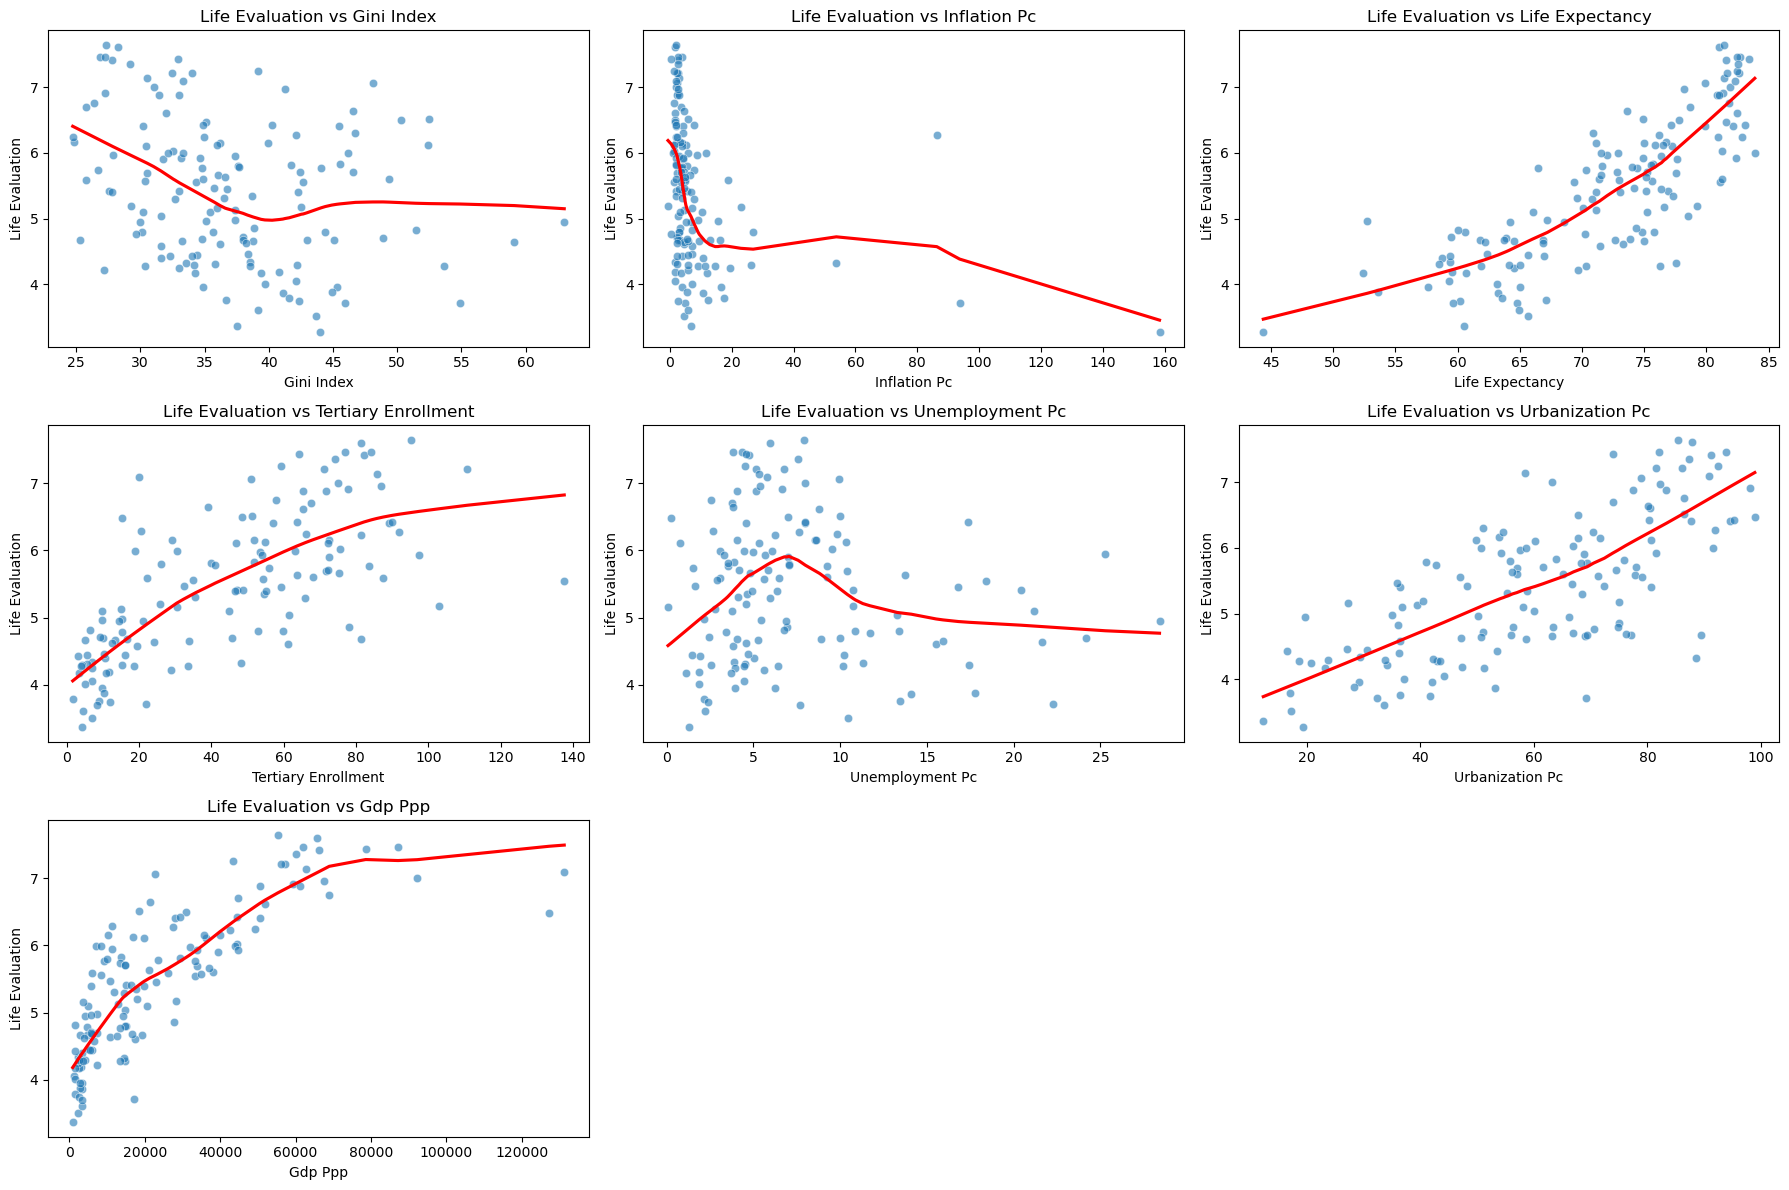

In [ ]:
# Visual diagnostics: scatter + LOESS smoothing to inspect linearity and potential transformations
variables = ["gini_index", "inflation_pc", "life_expectancy", "tertiary_enrollment", "unemployment_pc", "urbanization_pc", "gdp_ppp"]
plt.figure(figsize=(18, 12))
for i, var in enumerate(variables, 1):
    plt.subplot(3, 3, i)
    # scatter plot of variable vs life evaluation
    sns.scatterplot(data=joined_df_agg_cleaned, x=var, y="life_eval", alpha=0.6)
    # add a smoothed trend line to check for non-linear patterns
    sns.regplot(data=joined_df_agg_cleaned, x=var, y="life_eval", scatter=False, lowess=True, color="red")
    plt.title(f"Life Evaluation vs {var.replace('_', ' ').title()}")
    plt.xlabel(var.replace("_", " ").title())
    plt.ylabel("Life Evaluation")
plt.tight_layout()


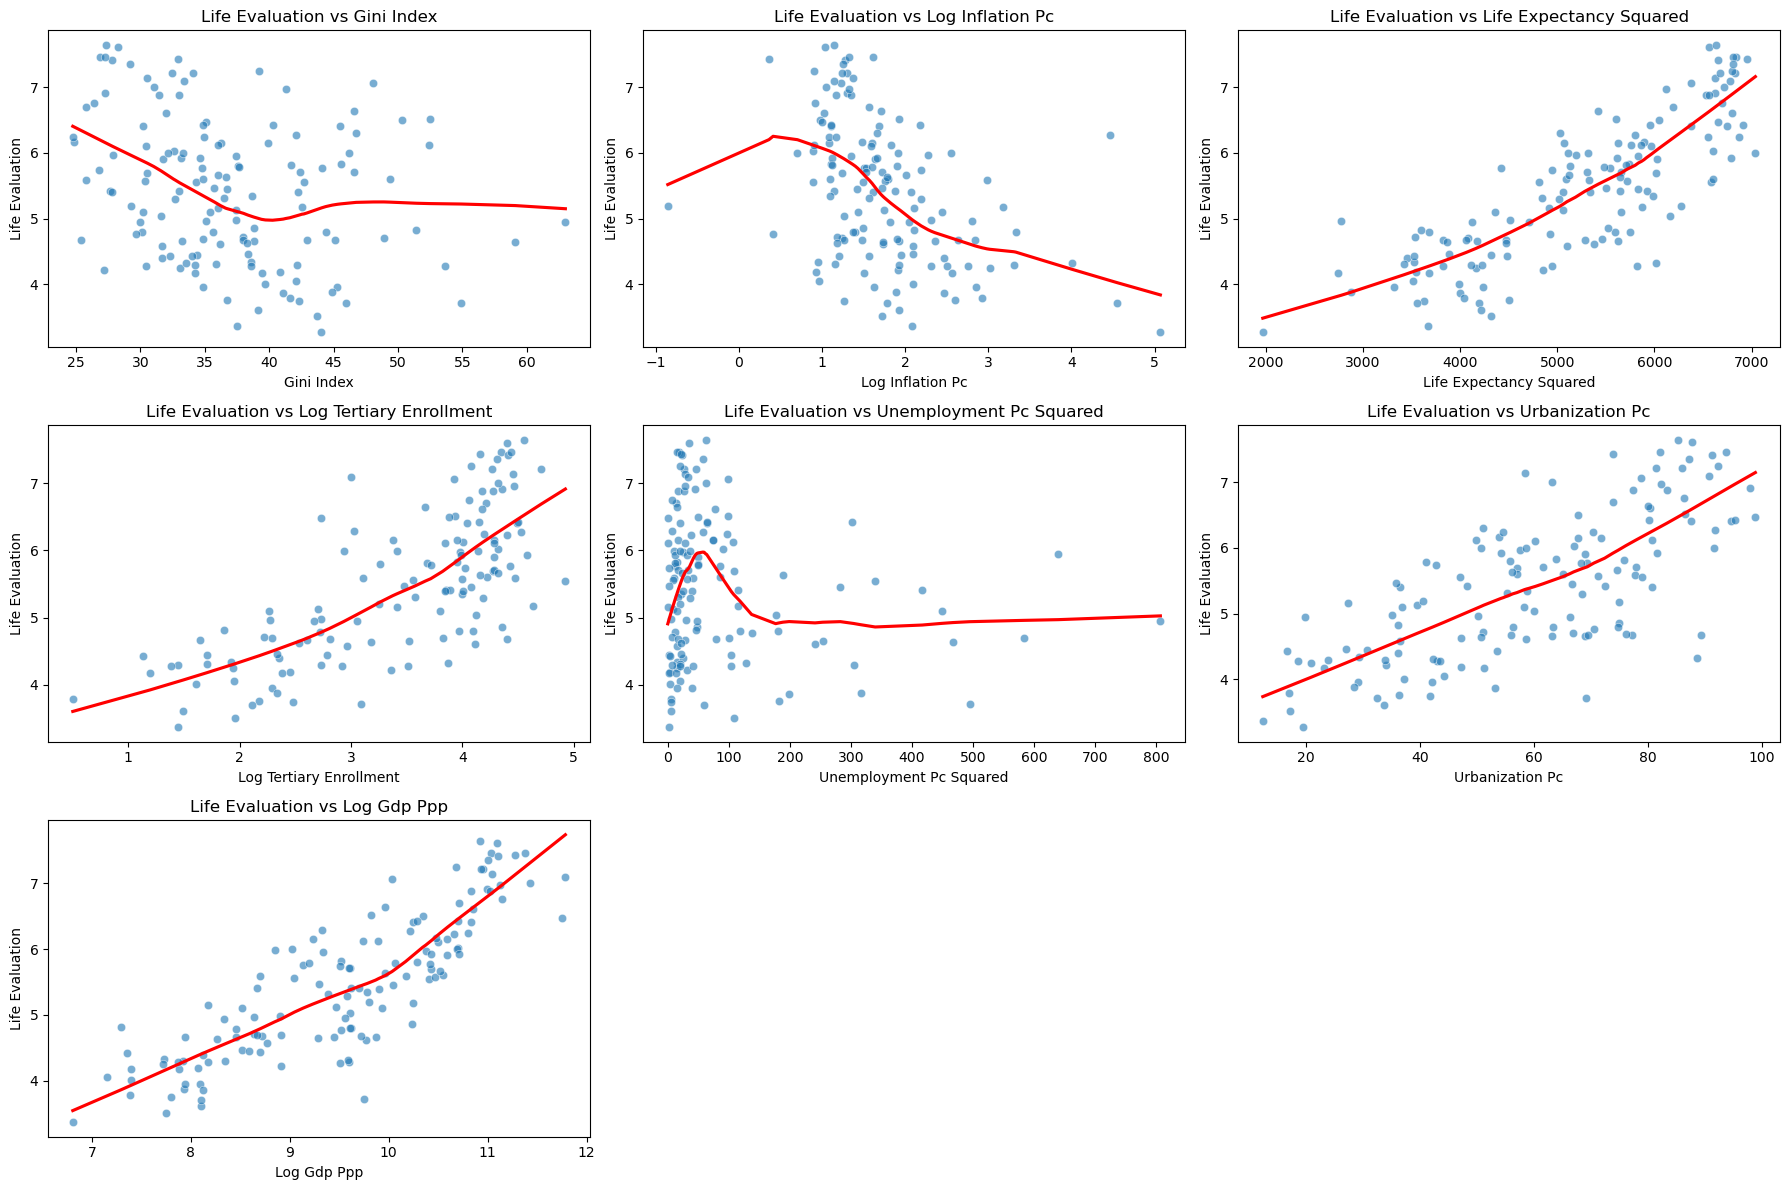

In [ ]:
# Based on the plots, we can try some transformations to improve linearity
joined_df_agg_cleaned["log_gdp_ppp"] = np.log(joined_df_agg_cleaned["gdp_ppp"])
joined_df_agg_cleaned["log_tertiary_enrollment"] = np.log(joined_df_agg_cleaned["tertiary_enrollment"])
joined_df_agg_cleaned["log_inflation_pc"] = np.log(joined_df_agg_cleaned["inflation_pc"] + 1)  # Adding 1 to avoid log(0)
joined_df_agg_cleaned["unemployment_pc_squared"] = joined_df_agg_cleaned["unemployment_pc"] ** 2
joined_df_agg_cleaned["life_expectancy_squared"] = np.square(joined_df_agg_cleaned["life_expectancy"])

variables = ["gini_index", "log_inflation_pc", "life_expectancy_squared", "log_tertiary_enrollment", "unemployment_pc_squared", "urbanization_pc", "log_gdp_ppp"]
plt.figure(figsize=(18, 12))
for i, var in enumerate(variables, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(data=joined_df_agg_cleaned, x=var, y="life_eval", alpha=0.6)
    sns.regplot(data=joined_df_agg_cleaned, x=var, y="life_eval", scatter=False, lowess=True, color="red")
    plt.title(f"Life Evaluation vs {var.replace('_', ' ').title()}")
    plt.xlabel(var.replace("_", " ").title())
    plt.ylabel("Life Evaluation")
plt.tight_layout()

In [ ]:
# Cross-sectional OLS specifications: original and linearized variants
model0 = smf.ols(
    "life_eval ~ urbanization_pc + tertiary_enrollment + gdp_ppp + unemployment_pc + inflation_pc + life_expectancy + gini_index",
    data=joined_df_agg_cleaned
).fit(cov_type="HC0")  # robust SEs

# model with transformed (log/squared) variables to improve linearity
model0lin = smf.ols(
    "life_eval ~ urbanization_pc + log_tertiary_enrollment + log_gdp_ppp + unemployment_pc + unemployment_pc_squared + log_inflation_pc + life_expectancy + life_expectancy_squared + gini_index",
    data=joined_df_agg_cleaned
).fit(cov_type="HC0")

star = Stargazer([model0, model0lin])
star.covariate_order(["Intercept", "urbanization_pc", "gini_index", "gdp_ppp", "tertiary_enrollment", "inflation_pc", "life_expectancy", "unemployment_pc",
                      "log_gdp_ppp", "log_tertiary_enrollment", "unemployment_pc_squared", "log_inflation_pc", "life_expectancy_squared"])
star.title(title="Cross-sectional regression with controls")
star.custom_columns(["Original Variables", "Linearized Variables"])
star

According to our cross-sectional model, a one percentage point increase in urbanization is associated with a 0.007-point increase in life evaluation (0–10), ceteris paribus. The coefficient is statistically significant but in real-life terms small.

Transforming panel data into a cross-section allows us to get quick results, but it essentially discards variation and may miss dynamics captured by panel methods.

# Part III: Preparing panel data for regressions

**3.1 Dealing with missing data**

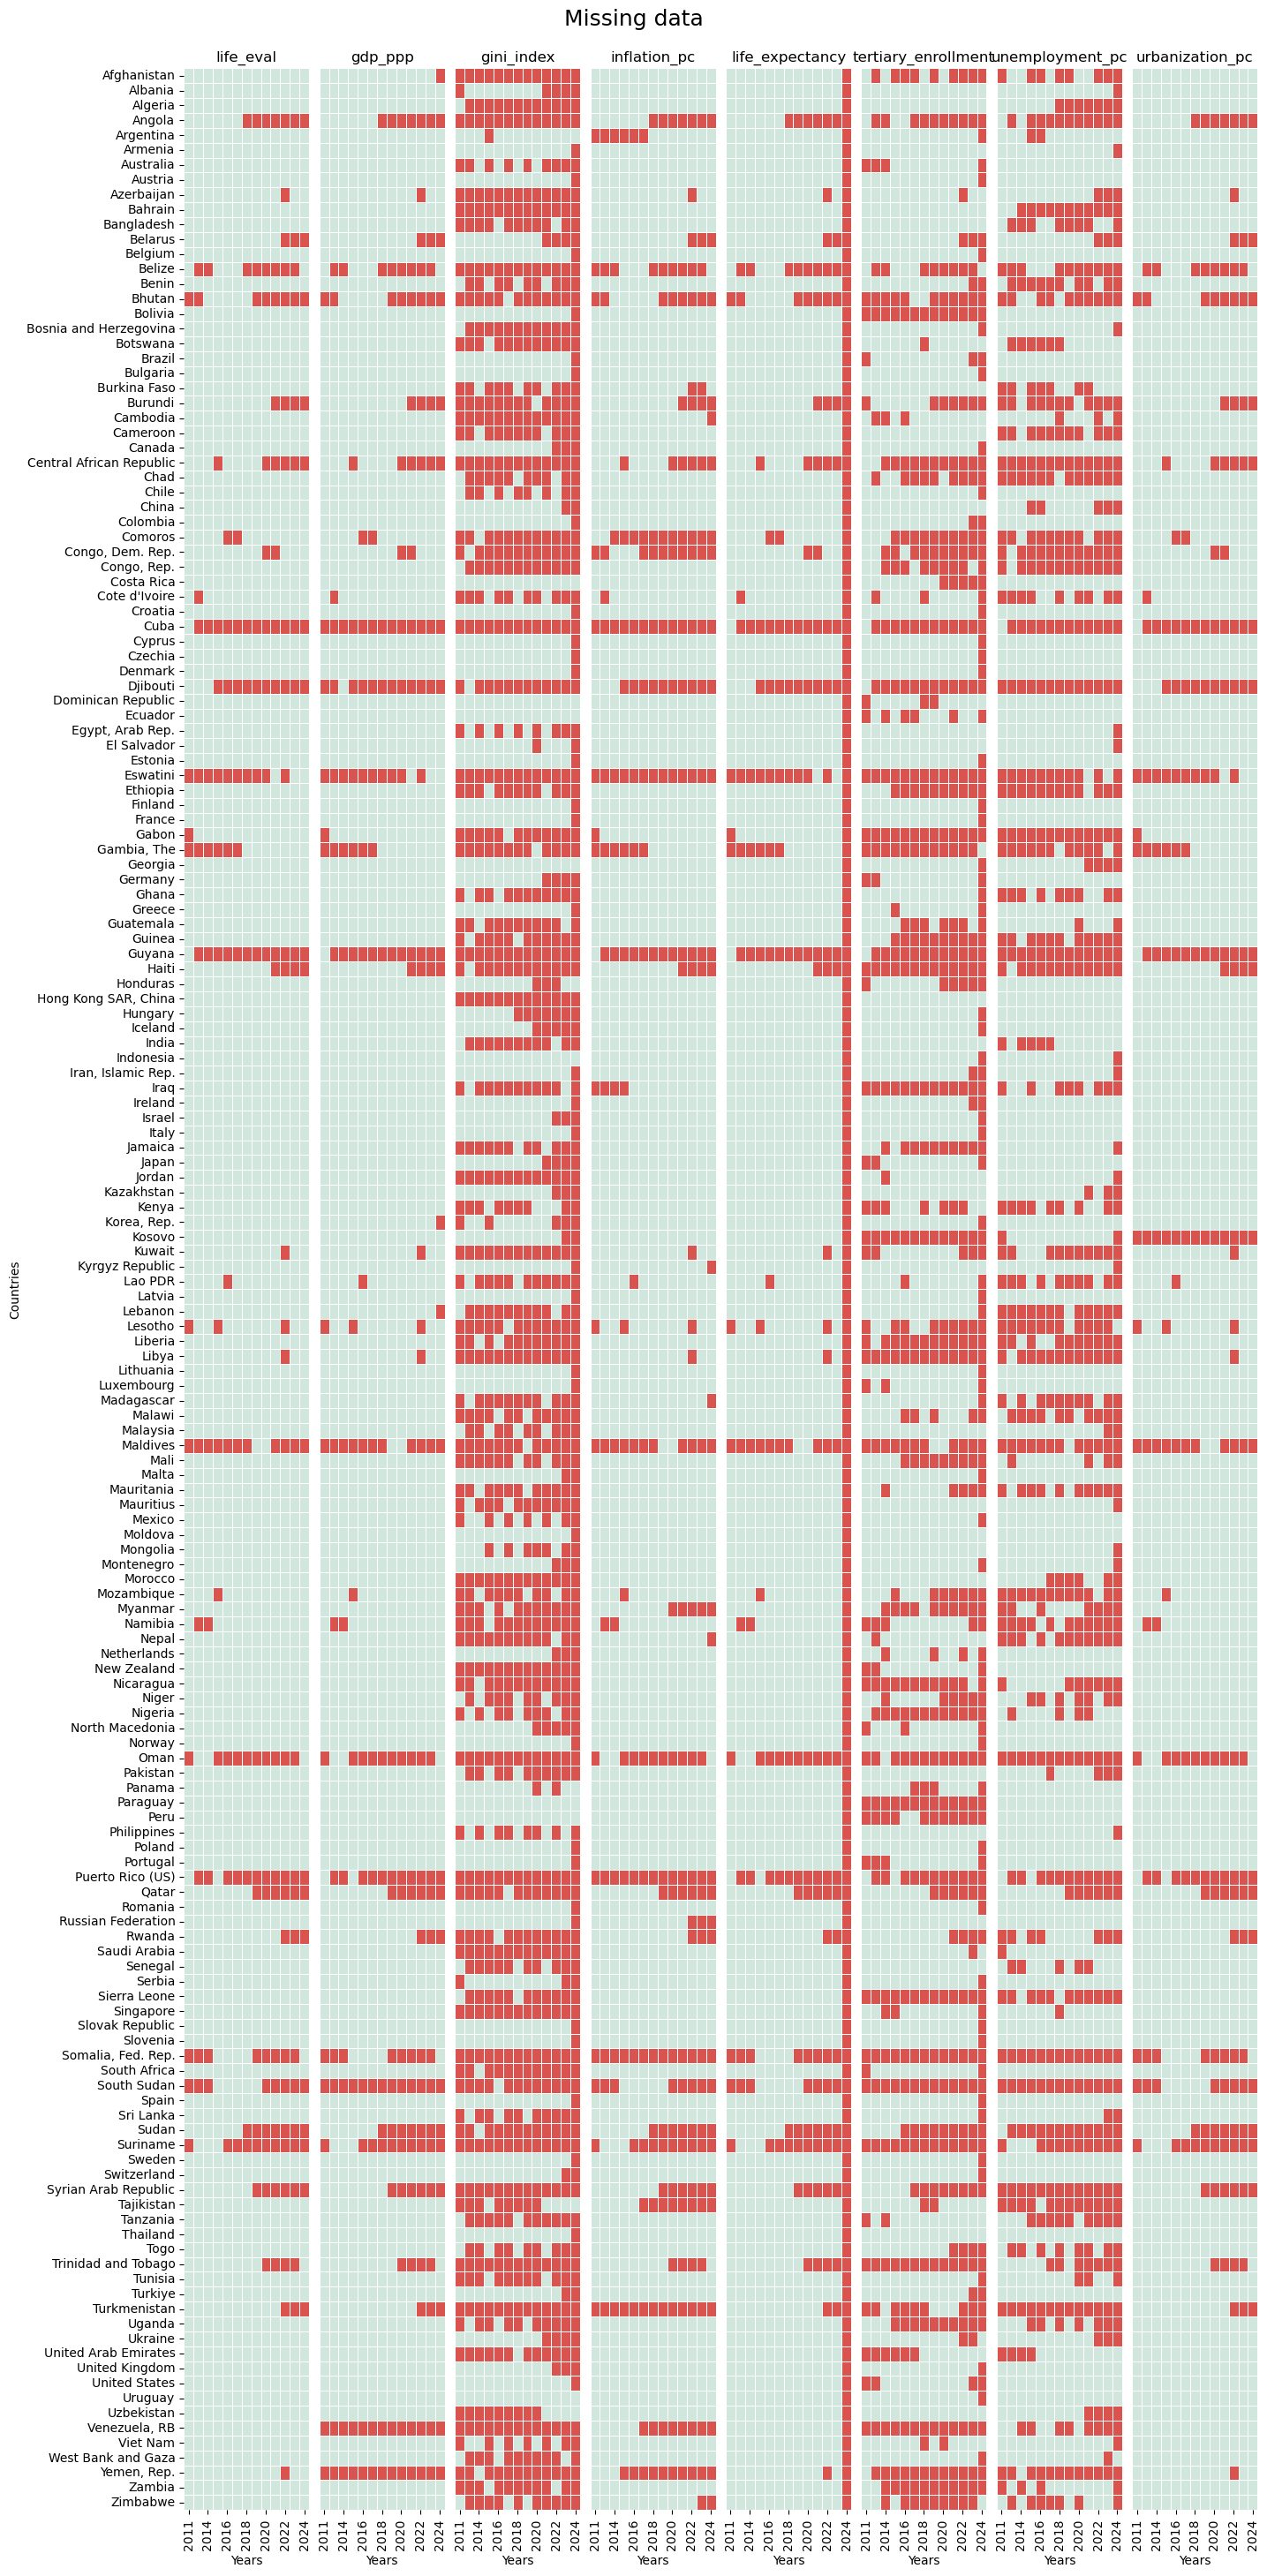

In [ ]:
def missing_heat(index,columns, n_of_var):
    global variables #enables us to use the variables outside of the function
    global missing
    missing = {}  # ensure dictionary is emptied each time the function runs

    variables = joined_df.columns[2:]
    for var in variables:
        # create a wide-format table with countries as rows and years as columns, add it to the dictionary
        missing[var] = joined_df.pivot(index=index, columns=columns, values=var)

    # create a row of heatmap subplots (one subplot per variable)
    fig, axes = plt.subplots(1, n_of_var, figsize=(15, 30))
    fig.suptitle("Missing data", fontsize=18)
    for n, var in enumerate(missing):
        if n == 0:
            ax = sns.heatmap(missing[var].isnull(), 
                        cbar=False, 
                        cmap=["#d1e7dd", "#d9534f"], 
                        linewidths=0.5, 
                        linecolor="white",
                        ax=axes[n])
            ax.set(xlabel="Years", ylabel="Countries", title=var)
        else:
            ax = sns.heatmap(missing[var].isnull(), 
                cbar=False, 
                cmap=["#d1e7dd", "#d9534f"],
                linewidths=0.5, 
                linecolor="white",
                yticklabels=False,  # disable y axis for every plot except the first
                ax=axes[n])
            ax.set(xlabel="Years", ylabel="", title=var)
    plt.tight_layout(pad=3, w_pad=0.5, h_pad=1.0)

missing_heat("country_name", "year", 8)

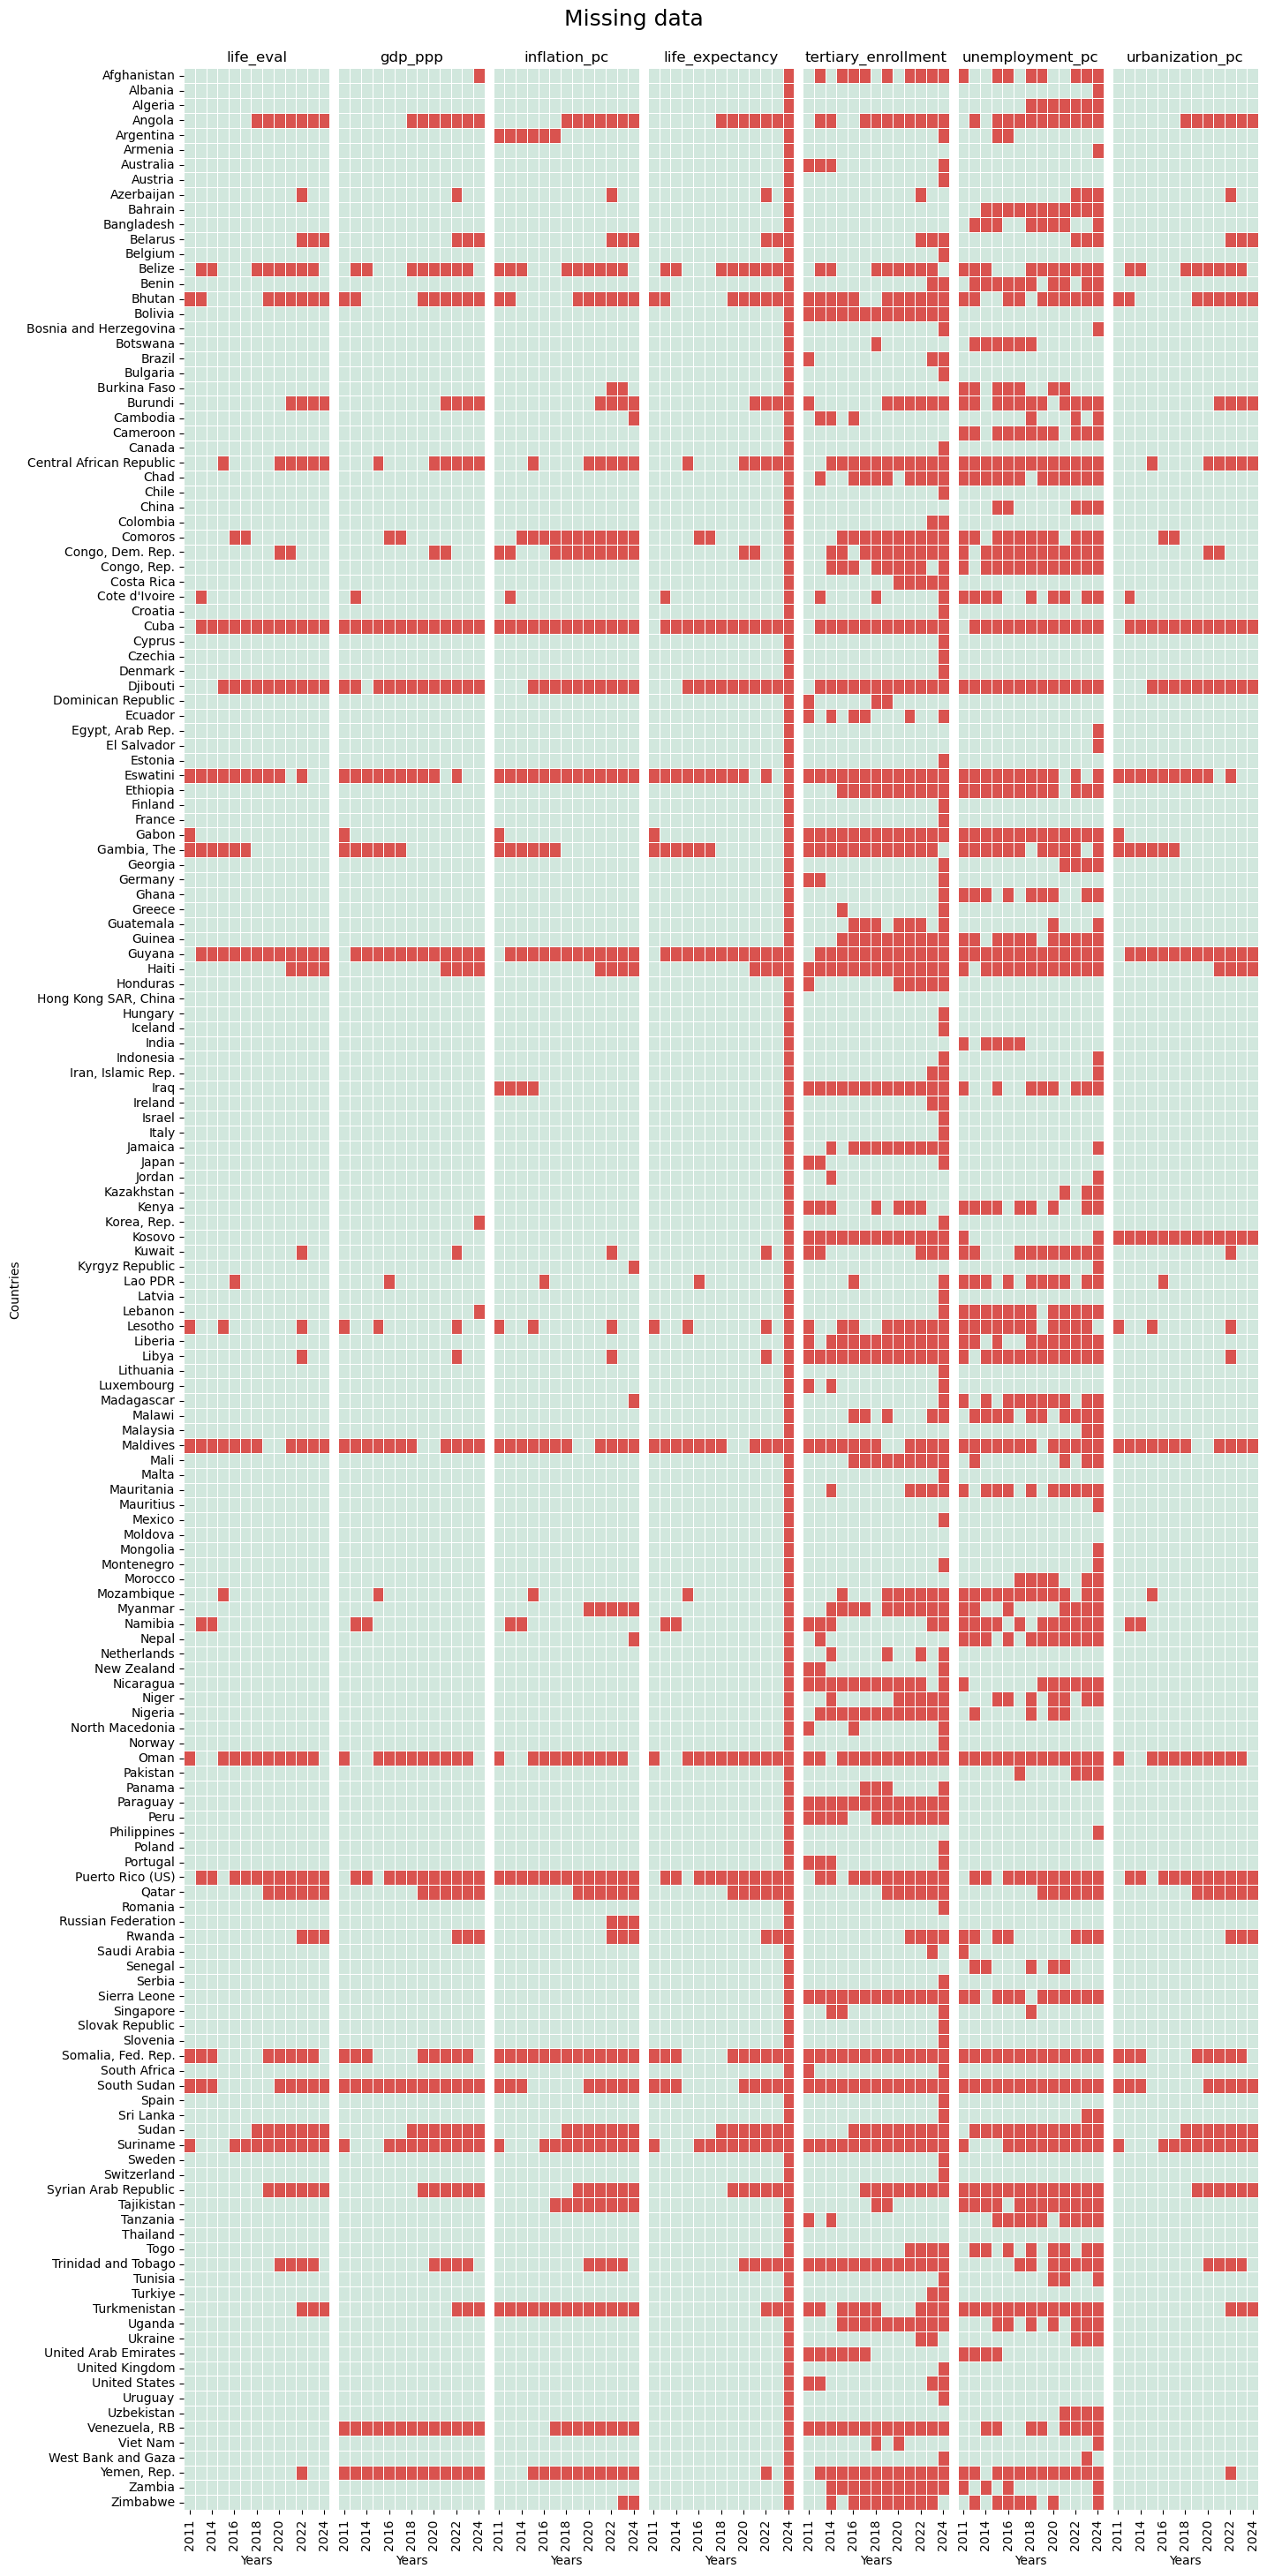

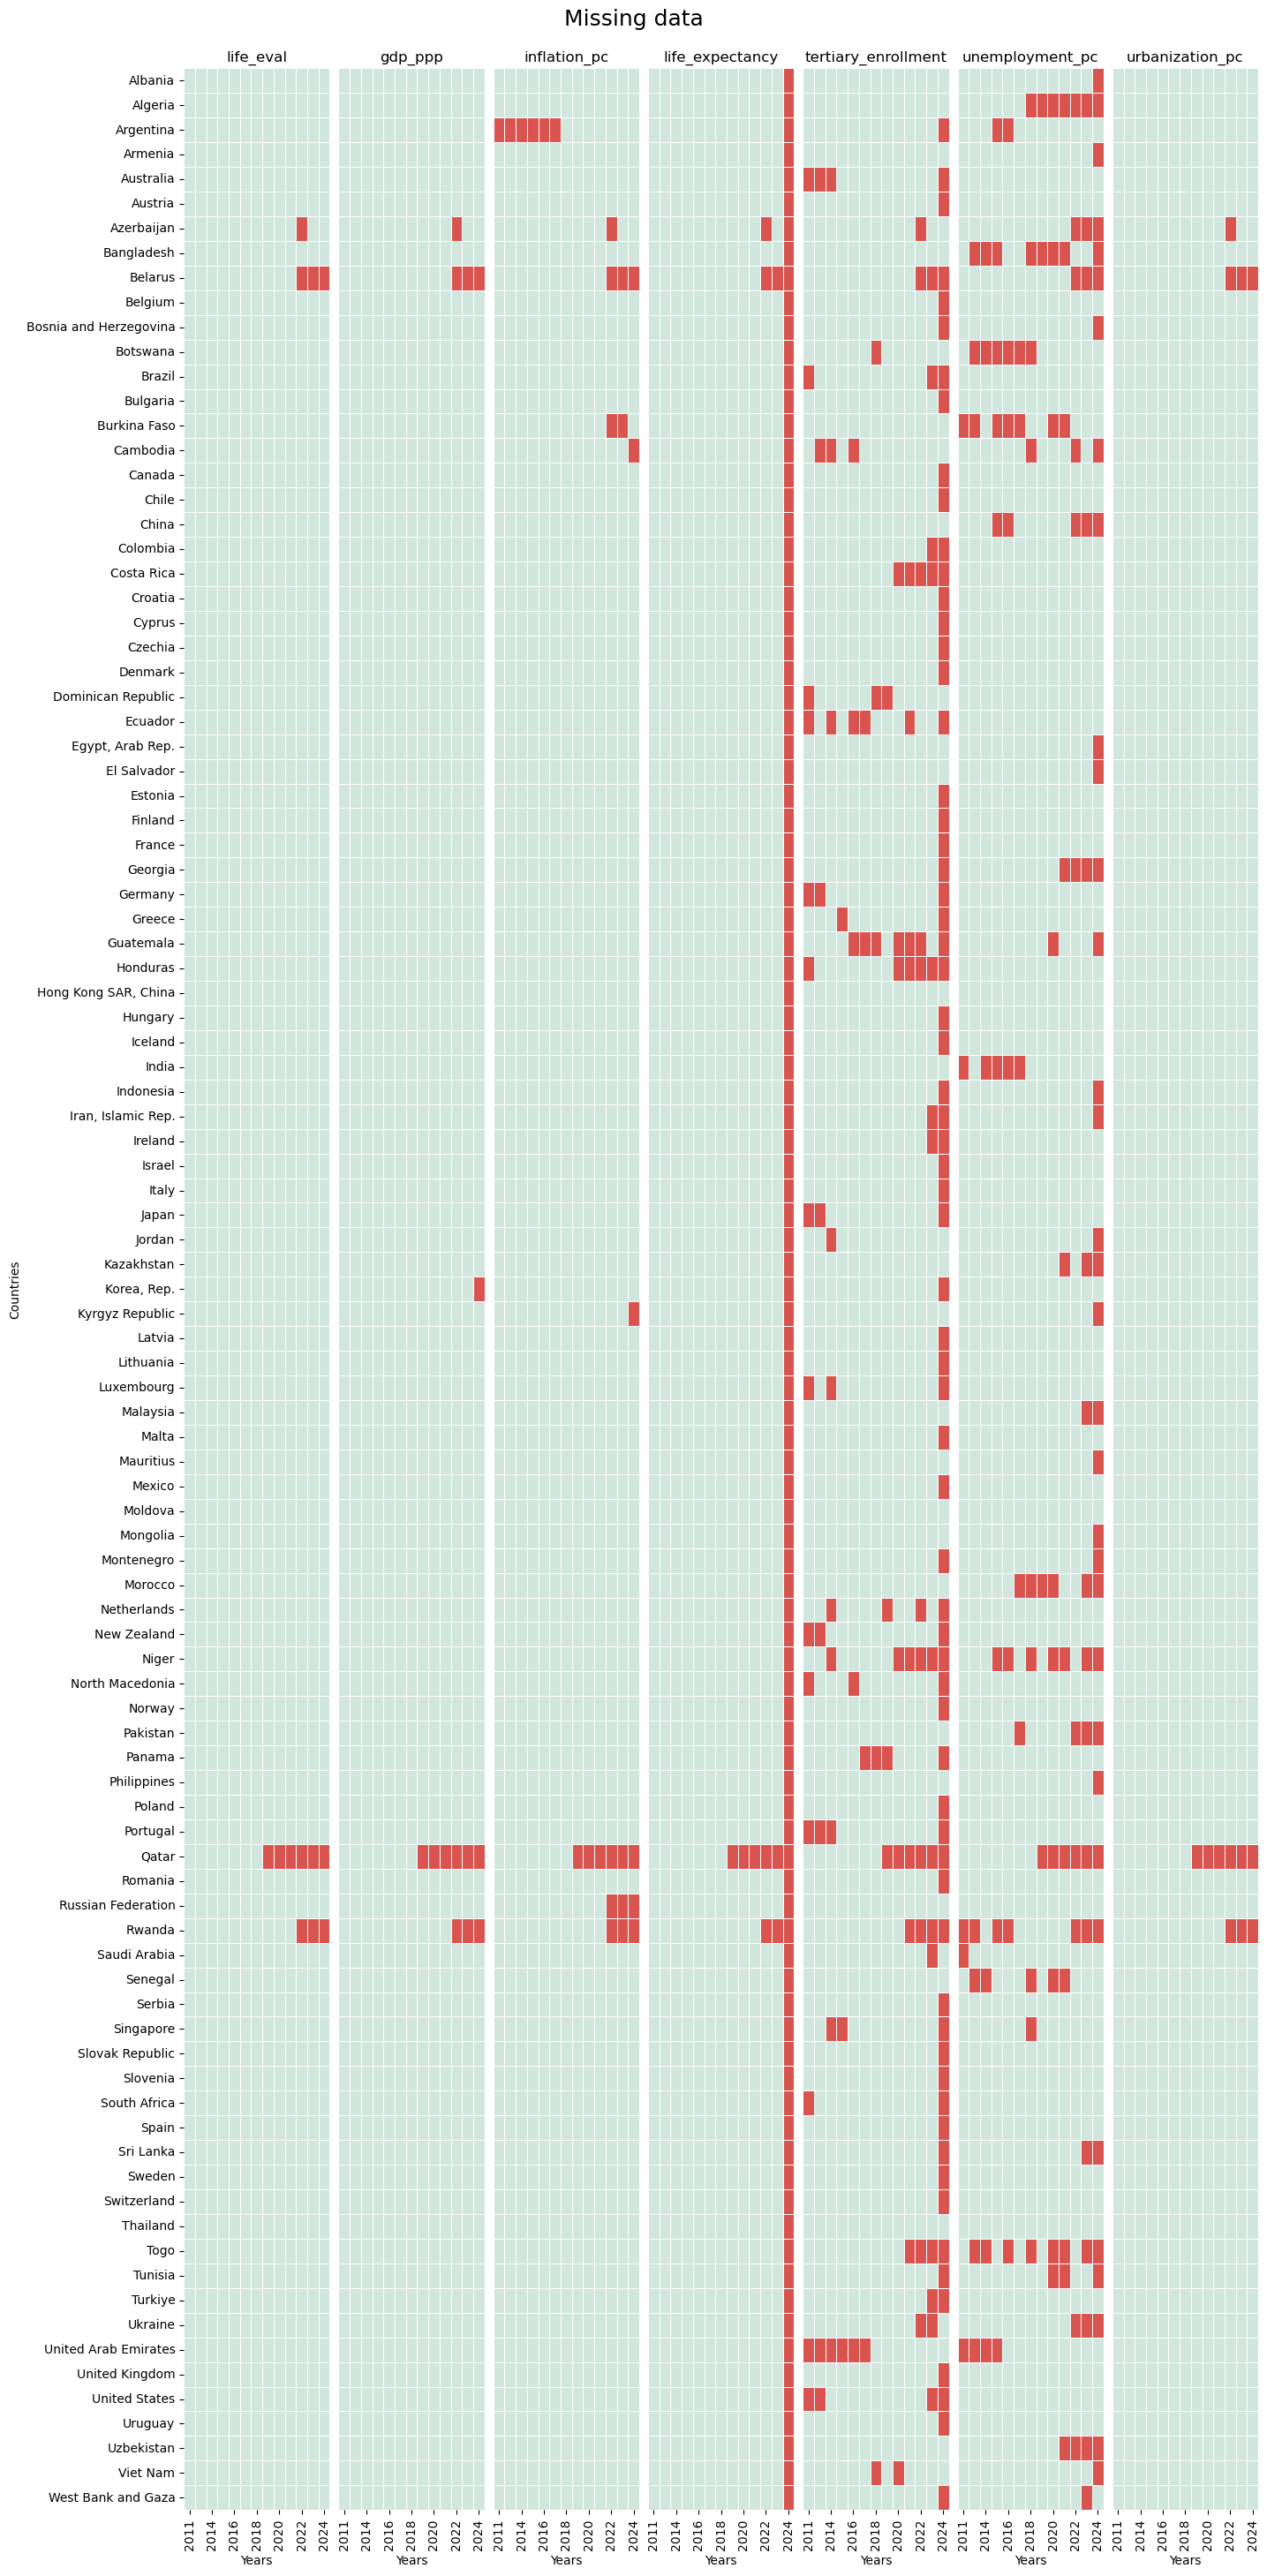

In [ ]:
# Drop variables/countries with too much missing and interpolate small gaps
joined_df.drop(columns="gini_index", inplace=True)  # too sparse to use in panel analysis
missing_heat("country_name", "year", 7)

# compute how many missing observations each country has per variable
missing_sums = {}
for var in variables:
    missing_sums[var] = missing[var].isnull().sum(axis=1)

# if a country is missing 9 or more years for any variable, mark it for dropping
to_drop = []
for table in missing_sums.values():
    to_drop += list(table[table >= 9].index)

to_drop = set(to_drop)
joined_df = joined_df[~joined_df["country_name"].isin(to_drop)]

# re-check missingness after removals
missing_heat("country_name", "year", 7)  # check results

In [ ]:
# Manually drop Qatar and Algeria; both have many missing years in recent periods
joined_df = joined_df[joined_df["country_name"] != "Qatar"] 
joined_df = joined_df[joined_df["country_name"] != "Algeria"]

2013 is missing from all datasets for some reason. For our analysis it would be preferable to avoid abrupt 'jumps' in the series. Since the previous and following years often have data, interpolating 2013 should be acceptable in most cases.

In [81]:
countries = joined_df["country_name"].unique()
min_year = joined_df["year"].min()
max_year = joined_df["year"].max()
all_years = range(min_year, max_year + 1)

idx = pd.MultiIndex.from_product([countries, all_years], names=["country_name", "year"])
joined_df = joined_df.set_index(["country_name", "year"])
joined_df = joined_df.reindex(idx)
joined_df = joined_df.reset_index()

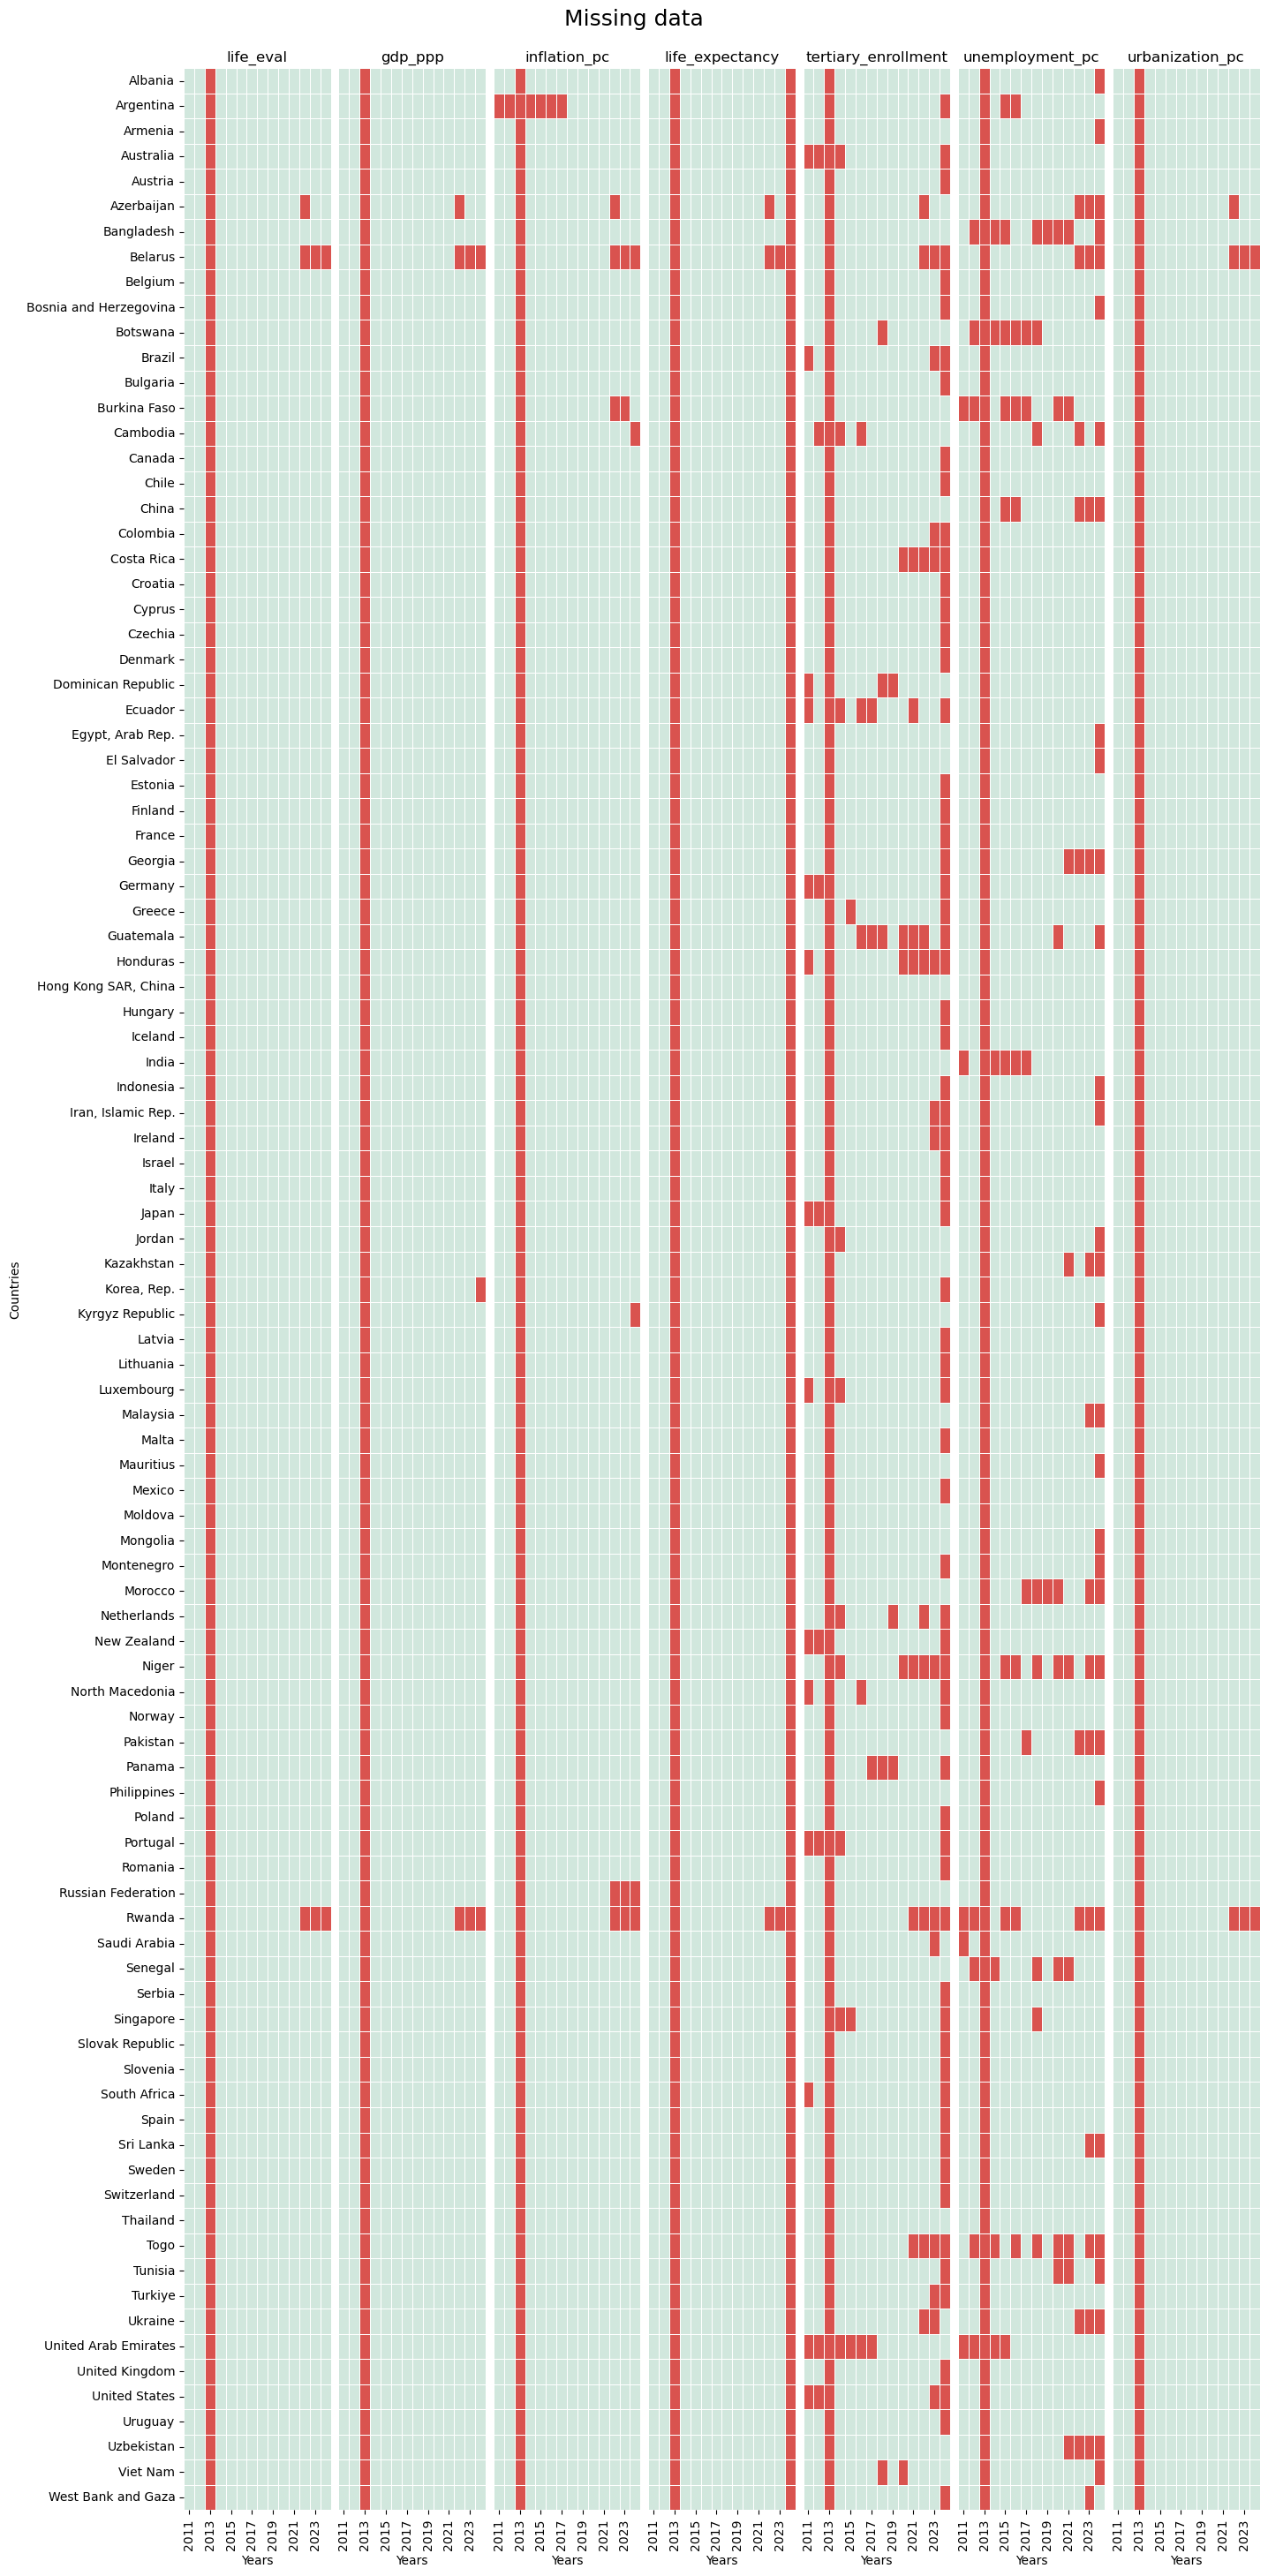

In [82]:
missing_heat("country_name", "year", 7)

In [ ]:
# sort by country and year to ensure correct order before interpolating
joined_df.sort_values(by=["country_name", "year"], inplace=True)
joined_df.reset_index(drop=True, inplace=True)
joined_df[variables] = joined_df.groupby("country_name")[variables].transform(lambda group: group.interpolate(method="linear", limit_direction="both"))

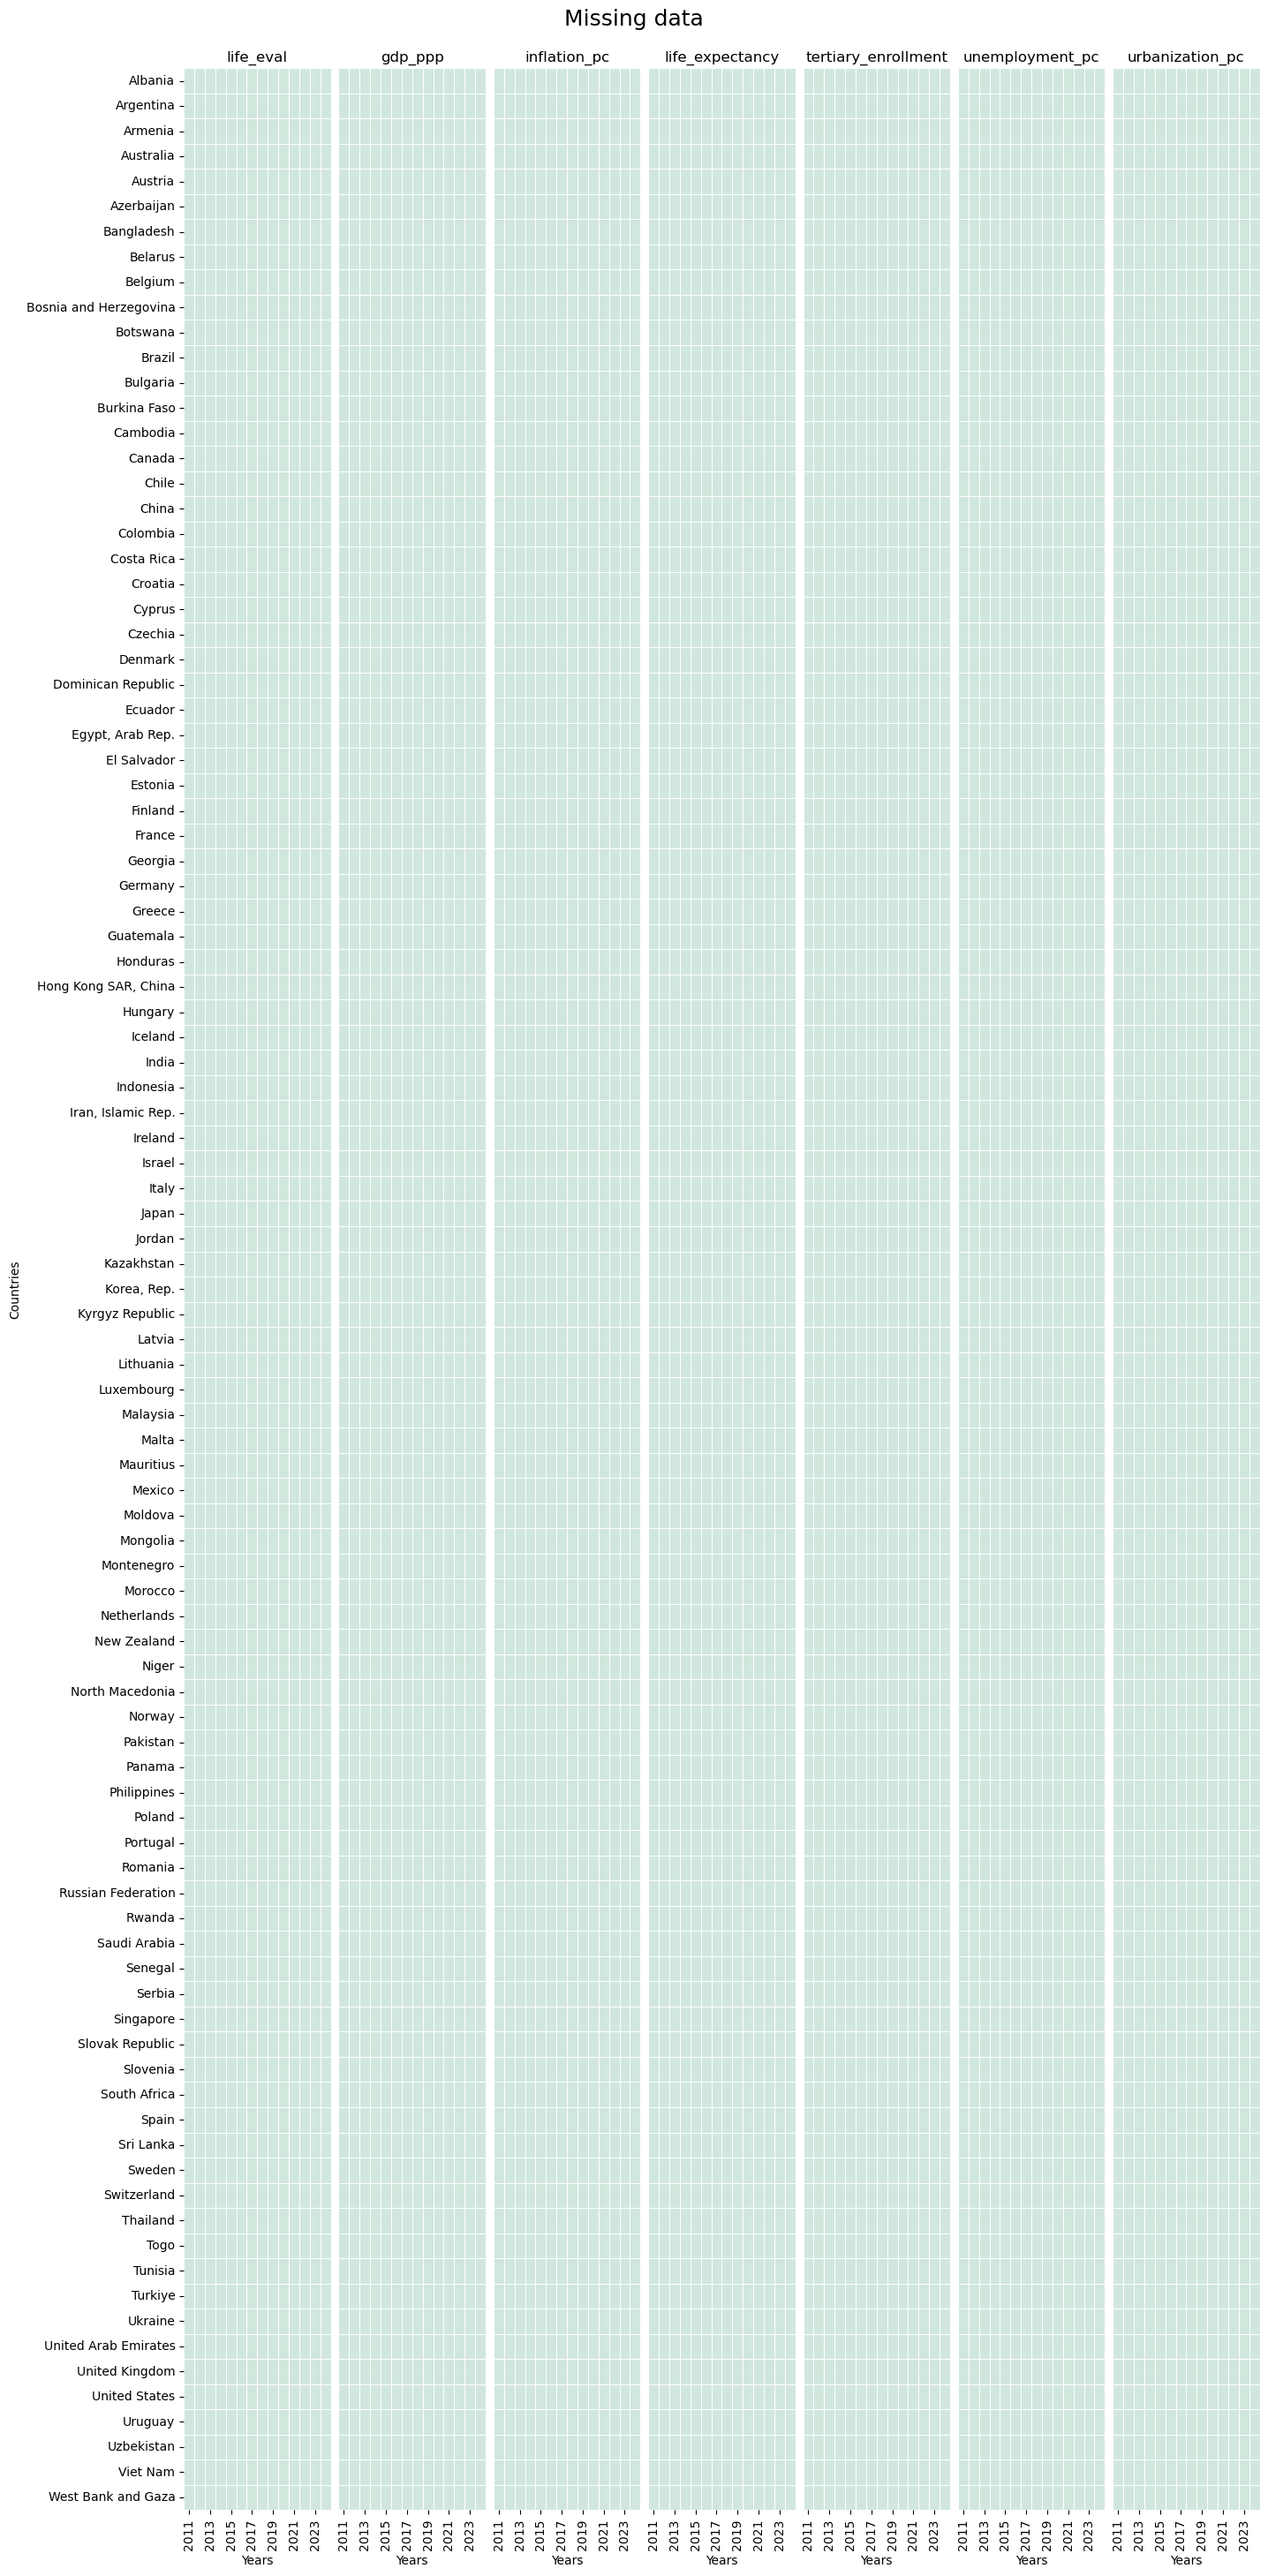

In [84]:
missing_heat("country_name", "year", 7)

# IV. Panel data analysis

**4.1 Naive OLS with year and country fixed effects**

In [ ]:
# Naive OLS with country and year fixed effects (clustered SEs by country)
model1 = smf.ols(
    "life_eval ~ urbanization_pc + C(country_name) + C(year)",
    data=joined_df
).fit(cov_type="cluster", cov_kwds={"groups": joined_df["country_name"]})

# Note: with country fixed effects, the urbanization coefficient captures within-country changes only.

**4.2 OLS with year and country fixed effects and controls for quality of life proxies**

In [ ]:
# Prepare transformed variables for panel regressions
joined_df["log_gdp_ppp"] = np.log(joined_df["gdp_ppp"])
joined_df["log_tertiary_enrollment"] = np.log(joined_df["tertiary_enrollment"])
# set small negative inflation values to zero before logging (few observations affected)
joined_df.loc[joined_df["inflation_pc"] < 0, "inflation_pc"] = 0
joined_df["log_inflation_pc"] = np.log(joined_df["inflation_pc"] + 1)  # Adding 1 to avoid log(0)
joined_df["unemployment_pc_squared"] = joined_df["unemployment_pc"] ** 2
joined_df["life_expectancy_squared"] = np.square(joined_df["life_expectancy"])

In [ ]:
# OLS with controls and fixed effects (clustered SEs by country)
model2 = smf.ols(
    "life_eval ~ urbanization_pc + log_inflation_pc + log_tertiary_enrollment + log_gdp_ppp + unemployment_pc + unemployment_pc_squared + life_expectancy + life_expectancy_squared + C(country_name) + C(year)",
    data=joined_df
).fit(cov_type="cluster", cov_kwds={"groups": joined_df["country_name"]})

star = Stargazer([model1, model2])
star.covariate_order(["Intercept", "urbanization_pc", "log_gdp_ppp", "log_inflation_pc", "life_expectancy", "life_expectancy_squared", "unemployment_pc", "unemployment_pc_squared", "log_tertiary_enrollment"])
star.custom_columns(["Naive", "With controls"])
star

According to these models there is no causal relationship between happiness (life evaluation) and urbanization, even when controlling for various relevant indicators. The issue with this model is that by allowing fixed effects for countries, the differences in urbanization between countries do not count, the coefficient of urbanization only shows within country effect of change. Since within country urbanization changes quite slowly it is not surprising that the coefficient of interest is small. To solve this we use the Mundlak model.

**4.3. Mundlak model**

In [ ]:
# Create country means for each predictor
predictors = [
    "urbanization_pc", 
    "log_gdp_ppp", 
    "log_tertiary_enrollment", 
    "unemployment_pc",
    "unemployment_pc_squared",
    "life_expectancy",
    "life_expectancy_squared",
    "log_inflation_pc",
]

for var in predictors:
    # mean_{var} represents the country-level (between) component
    joined_df[f"mean_{var}"] = joined_df.groupby("country_name")[var].transform("mean")

In [ ]:
formula = """
life_eval ~
    urbanization_pc +
    log_gdp_ppp +
    log_tertiary_enrollment +
    log_inflation_pc +
    life_expectancy +
    life_expectancy_squared +
    unemployment_pc +
    unemployment_pc_squared +

    mean_urbanization_pc +
    mean_log_gdp_ppp +
    mean_log_tertiary_enrollment +
    mean_log_inflation_pc +
    mean_life_expectancy +
    mean_life_expectancy_squared +
    mean_unemployment_pc +
    mean_unemployment_pc_squared +
    C(year)
"""

# Mundlak specification: includes both within-country deviations and country means
model3 = smf.ols(formula=formula, data=joined_df).fit(cov_type="cluster", cov_kwds={"groups": joined_df["country_name"]})

star = Stargazer([model1, model2, model3])
star.covariate_order([
    "Intercept",
    "urbanization_pc",
    "log_gdp_ppp",
    "unemployment_pc",
    "unemployment_pc_squared",
    "log_inflation_pc",
    "log_tertiary_enrollment",
    "life_expectancy",
    "life_expectancy_squared",      

    "mean_urbanization_pc",
    "mean_log_gdp_ppp",
    "mean_unemployment_pc",
    "mean_unemployment_pc_squared",
    "mean_log_inflation_pc",
    "mean_log_tertiary_enrollment",
    "mean_life_expectancy",
    "mean_life_expectancy_squared",
    
])
star.custom_columns(["Naive", "With controls", "Mundlak model"])
star

In [ ]:
# Extract country-level residuals ("cultural characteristics") from Mundlak model
joined_df['culture_residual'] = model3.resid
country_culture = joined_df.groupby('country_name')['culture_residual'].mean().sort_values()

country_culture

country_name
Hong Kong SAR, China   -1.791734
Bulgaria               -1.080799
Japan                  -1.068481
Sri Lanka              -1.004395
Singapore              -0.918072
                          ...   
Guatemala               0.815015
Brazil                  0.832438
Uzbekistan              0.883313
Finland                 1.039713
Costa Rica              1.064906
Name: culture_residual, Length: 97, dtype: float64

These models show that urbanization has little to no effect on life evaluation when controlling for other factors. The only consistently significant predictors are GDP PPP per capita and unemployment; in some specifications, country-level "cultural characteristics" (model residuals) also appear important.

The Mundlak model yields an interesting result consistent with adaptation effects in behavioral economics: the within-country coefficient on log GDP (≈1.128) exceeds the between-country coefficient (≈0.465), suggesting that income growth raises happiness more than does living in a naturally richer country. 

Further analysis could examine multicollinearity of variables (GDP may absorb part of the urbanization effect) and test interactions or non-linearities to uncover potential patterns between urbanization and life evaluation.

## Appendix

In [ ]:
#Full models
star = Stargazer([model1,model2,model3])
star.custom_columns(["Naive", "With controls", "Mundlak model"])
star